# 作業 : (Kaggle)鐵達尼生存預測
***
- 分數以網站評分結果為準, 請同學實際將提交檔(*.csv)上傳試試看  
https://www.kaggle.com/c/titanic/submit

# [作業目標]
- 試著模仿範例寫法, 在鐵達尼生存預測中, 觀察觀查混合泛化 (Blending) 的寫法與效果

# [作業重點]
- 觀察混合泛化的準確度 (In[14]), 是否比單一模型準確度為高 (In[11~13])  
- 除了我們的權重, 同學也可以試著自行調整權重 (注意:權重和=1), 看看有什麼影響
- Hint : 除了權重, 分類預測的調整, 還可以調整什麼地方?

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

data_path = 'data/'
df_train_o = pd.read_csv(data_path + 'titanic_train.csv')
df_test_o = pd.read_csv(data_path + 'titanic_test.csv')

train_Y = df_train_o['Survived']
ids = df_test_o['PassengerId']
df_train = df_train_o.drop(['PassengerId', 'Survived'] , axis=1)
df_test = df_test_o.drop(['PassengerId'] , axis=1)
df = pd.concat([df_train,df_test])
df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [2]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100 #算出每個類別空值所佔的比率
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False) #丟掉沒有空值的類別
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
Cabin,77.463713
Age,20.091673
Embarked,0.152788
Fare,0.076394


## 引用

[資料分析&機器學習 第4.1講](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC4-1%E8%AC%9B-kaggle%E7%AB%B6%E8%B3%BD-%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E7%94%9F%E5%AD%98%E9%A0%90%E6%B8%AC-%E5%89%8D16-%E6%8E%92%E5%90%8D-a8842fea7077)

觀察每個類別與生存率的關係

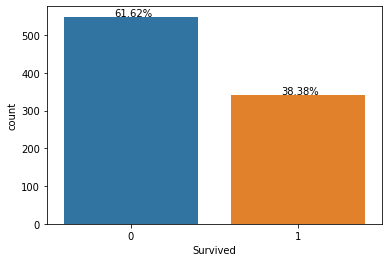

In [3]:
import seaborn as sns
ax = sns.countplot(train_Y)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train_Y)),
                (p.get_x()+0.3, #0.3只是調%的位置
                 p.get_height()+1))

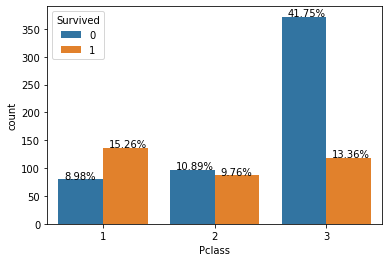

In [4]:
ax = sns.countplot(df_train['Pclass'], hue=train_Y)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train_Y)), 
                (p.get_x()+0.05, 
                 p.get_height()+1))

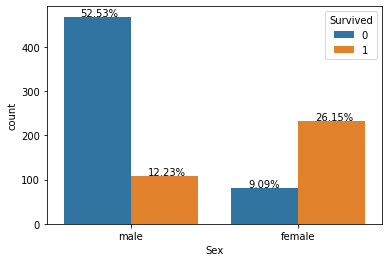

In [5]:
ax = sns.countplot(df_train['Sex'], hue=train_Y)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train_Y)), (p.get_x()+0.1, p.get_height()+1))

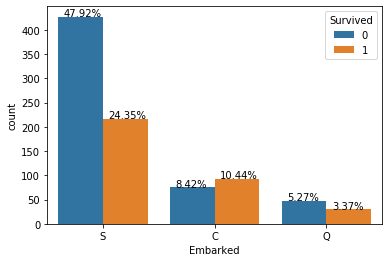

In [6]:
ax = sns.countplot(df_train['Embarked'], hue=train_Y)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train_Y)), (p.get_x()+0.05, p.get_height()+1))

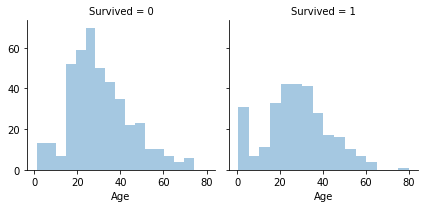

In [7]:
g = sns.FacetGrid(df_train_o, col='Survived')
g.map(sns.distplot, 'Age', kde=False)

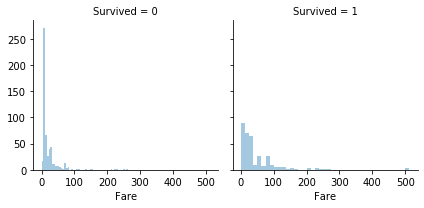

In [8]:
g = sns.FacetGrid(df_train_o, col='Survived')
g.map(sns.distplot, 'Fare', kde=False)

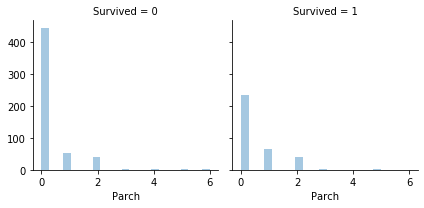

In [9]:
g = sns.FacetGrid(df_train_o, col='Survived')
g.map(sns.distplot, 'Parch', kde=False)  #Parch： of parents / children aboard the Titanic

In [10]:
df['Family_Size'] = df['Parch'] + df['SibSp'] #將父母小孩、兄弟姊妹合成成一個特徵

In [11]:
# 以下 In[3]~In[10] 只是鐵達尼預測中的一組特徵工程, 並以此組特徵工程跑參數, 若更換其他特徵工程, In[10]的參數需要重新跑
# Sex : 直接轉男 0 女 1
df["Sex"] = df["Sex"].map({"male": 0, "female":1})
# Fare : 用 log 去偏態, 0 則直接取 0
df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
# Age : 缺值用中位數補
df["Age"] = df["Age"].fillna(df['Age'].median())

In [12]:
df['Title'] = df['Name'].str.split(", ", expand=True)[1]
print(df['Title'])
df['Title'] = df['Title'].str.split(".", expand=True)[0] #利用str.split(".")取出稱謂
print(df['Title'])

'''
# Title 的 特徵工程 : 將各種頭銜按照類型分類, 最後取 One Hot
df_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]
df["Title"] = pd.Series(df_title)
df["Title"] = df["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
df["Title"] = df["Title"].astype(int)
df = pd.get_dummies(df, columns = ["Title"])
'''

0                                 Mr. Owen Harris
1      Mrs. John Bradley (Florence Briggs Thayer)
2                                     Miss. Laina
3              Mrs. Jacques Heath (Lily May Peel)
4                               Mr. William Henry
                          ...                    
413                                     Mr. Woolf
414                                 Dona. Fermina
415                           Mr. Simon Sivertsen
416                                 Mr. Frederick
417                             Master. Michael J
Name: Title, Length: 1309, dtype: object
0          Mr
1         Mrs
2        Miss
3         Mrs
4          Mr
        ...  
413        Mr
414      Dona
415        Mr
416        Mr
417    Master
Name: Title, Length: 1309, dtype: object


'\n# Title 的 特徵工程 : 將各種頭銜按照類型分類, 最後取 One Hot\ndf_title = [i.split(",")[1].split(".")[0].strip() for i in df["Name"]]\ndf["Title"] = pd.Series(df_title)\ndf["Title"] = df["Title"].replace([\'Lady\', \'the Countess\',\'Countess\',\'Capt\', \'Col\',\'Don\', \'Dr\', \'Major\', \'Rev\', \'Sir\', \'Jonkheer\', \'Dona\'], \'Rare\')\ndf["Title"] = df["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})\ndf["Title"] = df["Title"].astype(int)\ndf = pd.get_dummies(df, columns = ["Title"])\n'

In [13]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [14]:
pd.crosstab(df['Title'],df['Sex']).T.style.background_gradient() #看稱謂的性別

Title,Capt,Col,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
Sex,,,,,,,,,,,,,,,,,,
0,1,4,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1,0
1,0,0,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0,1


In [15]:
#按照性別去整合稱謂
df['Title'] = df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','the Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
                                  ['Miss','Mrs','Miss','Mr','Mr','Mrs','Mrs','Mr','Mr','Mr','Mr','Mr','Mr','Mrs'])

In [16]:
# 新建:家庭大小 (Fsize)特徵, 並依照大小分別建獨立欄位
df["Fsize"] = df["SibSp"] + df["Parch"] + 1
df['Single'] = df['Fsize'].map(lambda s: 1 if s == 1 else 0)
df['SmallF'] = df['Fsize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF'] = df['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [17]:
# Ticket : 如果不只是數字-取第一個空白之前的字串(去除'.'與'/'), 如果只是數字-設為'X', 最後再取 One Hot
Ticket = []
for i in list(df.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0])
    else:
        Ticket.append("X")        
df["Ticket"] = Ticket
df = pd.get_dummies(df, columns = ["Ticket"], prefix="T")

In [18]:
# Cabib 依照第一碼分類, 再取 One Hot
df["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df['Cabin'] ])
df = pd.get_dummies(df, columns = ["Cabin"], prefix="Cabin")

In [19]:
# Embarked, Pclass 取 One Hot
df = pd.get_dummies(df, columns = ["Embarked"], prefix="Em")
df["Pclass"] = df["Pclass"].astype("category")
df = pd.get_dummies(df, columns = ["Pclass"], prefix="Pc")

# 捨棄 Name 欄位
df.drop(labels = ["Name"], axis = 1, inplace = True)

In [22]:
df = pd.get_dummies(df, columns = ["Title"], prefix="Title")

In [23]:
# 確認缺值 與 目前的資料表內容
na_check(df)
df.head()

,Missing Ratio


,Sex,Age,SibSp,Parch,Fare,Family_Size,Fsize,Single,SmallF,MedF,...,Em_C,Em_Q,Em_S,Pc_1,Pc_2,Pc_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,22.0,1,0,1.981001,1,2,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,1,38.0,1,0,4.266662,1,2,0,1,0,...,1,0,0,1,0,0,0,0,0,1
2,1,26.0,0,0,2.070022,0,1,1,0,0,...,0,0,1,0,0,1,0,1,0,0
3,1,35.0,1,0,3.972177,1,2,0,1,0,...,0,0,1,1,0,0,0,0,0,1
4,0,35.0,0,0,2.085672,0,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0


In [32]:
# 將資料最大最小化
df = MinMaxScaler().fit_transform(df)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df[:train_num]
test_X = df[train_num:]

# 使用三種模型 : 邏輯斯迴歸 / 梯度提升機 / 隨機森林, 參數使用 Random Search 尋找
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
lr = LogisticRegression(tol=0.001, 
                        penalty='l2', 
                        fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=0.1, 
                                  subsample=0.75, 
                                  n_estimators=250, 
                                  max_features=20,
                                  max_depth=6, 
                                  learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            max_features='sqrt', 
                            max_depth=6,
                            criterion='gini',
                            bootstrap=True)

In [25]:
'''
from sklearn.model_selection import GridSearchCV
# 設定要訓練的超參數組合
n_estimators = [200, 250, 300]
max_depth = [5, 6, 7]
max_features = [15, 20, 25, 30]
param_grid = dict(n_estimators=n_estimators, 
                  max_depth=max_depth, 
                  max_features = max_features)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(gdbt, param_grid, scoring='accuracy', n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(train_X, train_Y)

# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(grid_result.best_params_)
'''

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.0s finished


Best Accuracy: 0.842872 using {'max_depth': 6, 'max_features': 20, 'n_estimators': 250}
{'max_depth': 6, 'max_features': 20, 'n_estimators': 250}


In [26]:
'''
n_estimators = [50, 100, 150]
max_depth = [5, 6, 7, 8]
min_samples_split = [1, 2, 3]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators=n_estimators, 
                  max_depth=max_depth, 
                  min_samples_split = min_samples_split, 
                  min_samples_leaf = min_samples_leaf)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(rf, param_grid, scoring='accuracy', n_jobs=-1, verbose=1)

# 開始搜尋最佳參數
grid_result = grid_search.fit(train_X, train_Y)

# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print(grid_result.best_params_)
'''

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    3.1s


Best Accuracy: 0.836143 using {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    5.3s finished


In [44]:
lr = LogisticRegression(tol=0.001, 
                        penalty='l2', 
                        fit_intercept=True, C=1.0)
gdbt = GradientBoostingClassifier(tol=0.1, 
                                  subsample=0.75, 
                                  n_estimators=250, 
                                  max_features=20,
                                  max_depth=6, 
                                  learning_rate=0.03)
rf = RandomForestClassifier(n_estimators=100, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            max_features='sqrt', 
                            max_depth=8,
                            criterion='gini',
                            bootstrap=True)

In [45]:
# 線性迴歸預測檔 (結果有部分隨機, 請以 Kaggle 計算的得分為準, 以下模型同理)
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': lr_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_lr.csv', index=False) 

In [46]:
# 梯度提升機預測檔 
gdbt.fit(train_X, train_Y)
gdbt_pred = gdbt.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': gdbt_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_gdbt.csv', index=False)

In [47]:
# 隨機森林預測檔
rf.fit(train_X, train_Y)
rf_pred = rf.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'PassengerId': ids, 'Survived': rf_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_rf.csv', index=False)

# 作業
* 雖然同樣是混合泛化，分類預測其實與回歸預測有相當多的差異性，
因為鐵達尼預測的結果是 '生存/死亡'，輸出不是 0 就是 1  
因此要用權重混合時，需要以以機率的形式混合，因此我們在作業前幾格當中，先幫各位同學把預測值寫成了機率的形式  
(請同學把下列程式完成，並將結果提交到 Kaggle 網站看看結果)

* 但是光是這樣，分類問題的混合泛化就能比單模預測還要好嗎?  
已經快要期中考了，這裡請同學挑戰看看，還有沒有什麼方法可以改進混合泛化的結果?

In [48]:
from sklearn.metrics import accuracy_score
print("linear accuracy：", accuracy_score(lr.predict(train_X), train_Y))
print("gdbt accuracy：", accuracy_score(gdbt.predict(train_X), train_Y))
print("rf accuracy：", accuracy_score(rf.predict(train_X), train_Y))

linear accuracy： 0.8383838383838383
gdbt accuracy： 0.9528619528619529
rf accuracy： 0.8843995510662177


In [49]:
# 混合泛化預測檔 
"""
Your Code Here
"""
blending_pred = lr_pred*0.1 + gdbt_pred*0.1 + rf_pred*0.8
sub = pd.DataFrame({'PassengerId': ids, 'Survived': blending_pred})
sub['Survived'] = sub['Survived'].map(lambda x:1 if x>0.5 else 0) 
sub.to_csv('titanic_blending.csv', index=False)

在此案例中混合泛化並沒有比單一模型(rf)好